In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestRegressor 
from yellowbrick.model_selection import LearningCurve
from yellowbrick.features import Rank1D
from yellowbrick.regressor import ResidualsPlot

from MLDA.miscellaneous.save_and_load_files import load_object, save_object
from MLDA.ML_functions.ML_dict import splitDataAndAddToMLDict, addFeatImpToDict
from MLDA.plot_functions.model_visual import showFeatureImportanceForModels, showResidualsForModels, showLearningCurveForModels;

### The relevant columns are selected

In [3]:
# First we load the cleaned data from the DA_module
da_dict = load_object(
    '/home/jesper/Work/MLDA_app/MLDA/jupyter_DA/da_dict_N1.sav')

data = da_dict["data"]

"""Choosing vars for ML_dict"""
# Still pandas
ydata = data.iloc[:, -2:]  # Selecting all y
# print(xdata)

# ML_dictEN1: xdata = data.iloc[:, 1:-2]  # Selecting all x except 'rel_compact'
# ML_dictEN1: xdata = xdata.loc[:, xdata.columns != "orientation"]  # Excluding 'orientation'

xnames_ML_dictEN2 = ['wall_area', 'roof_area','orientation', 'glazing_area', 'glaz_area_distrib']
xdata = data[xnames_ML_dictEN2]


models = ["ransac", "forest"]

ML_dictEN2 = {}  # 


# Below here we init the ML_dict we want to use
# ML_dictEN1 = {}  # Energy dict excluding the two vars: 'rel_compact' and 'orientation'. ID is: xcols: [0, 1, 2, 3, 4, 5]_ycols: [0, 1]_['ransac', 'forest']_test_size: 0.2
test_size = 0.2

ML_dictEN2,type_ = splitDataAndAddToMLDict(
    df_xdata=xdata, df_ydata=ydata, ML_dict=ML_dictEN2, models=models, test_size=test_size
)

"""END Choosing vars for ML_dict"""


'END Choosing vars for ML_dict'

### Testing

In [4]:
da_dict = load_object(
    '/home/jesper/Work/MLDA_app/MLDA/jupyter_DA/da_dict_N1.sav')

data = da_dict["data"]
xnames_ML_dictEN2 = ['wall_area', 'roof_area','orientation', 'glazing_area', 'glaz_area_distrib']
xdata = data[xnames_ML_dictEN2]
X_train = xdata.to_numpy()
print(xdata)
Y_train = data['heat_load']
model = RANSACRegressor(min_samples=50, random_state=0) 
model.fit(X_train, Y_train)
print(X_train[0])
print(Y_train[0])
print(model.predict(X_train[0].reshape(1, -1)))
print(model.predict(X_train[7].reshape(1, -1)))
print(model.predict(X_train))
model.estimator_.coef_

     wall_area  roof_area  orientation  glazing_area  glaz_area_distrib
0        294.0     110.25            2           0.0                  0
1        294.0     110.25            3           0.0                  0
2        294.0     110.25            4           0.0                  0
3        294.0     110.25            5           0.0                  0
4        318.5     122.50            2           0.0                  0
..         ...        ...          ...           ...                ...
763      343.0     220.50            5           0.4                  5
764      367.5     220.50            2           0.4                  5
765      367.5     220.50            3           0.4                  5
766      367.5     220.50            4           0.4                  5
767      367.5     220.50            5           0.4                  5

[768 rows x 5 columns]
[294.   110.25   2.     0.     0.  ]
15.55
[27.28509148]
[26.01147025]
[27.28509148 27.19764811 27.11020475 27.0

array([ 0.04477647, -0.17210732, -0.08744337, 19.52507479,  0.09340144])

### Info about DA_dict and ML_dict structure below here

In [5]:
"""ML_dict structure"""
# ML_dict_Name1 = {'id': "xcols: [0, 1, 2, 3, 4, 5]_ycols: [0, 1]_['ransac', 'forest']_test_size: 0.2",
#                           'df_data': {dataframe with xdata and ydata}
#                           'xdata_names':
#                           'X': {'X_train': np.arrays
#                                 'X_test': np.arrays}
#                           'models': {'names': ['ransac', 'forest']} example
#                           'Y': {'yname1': {'pred':{'ransac': {'train': np.arrays, 'test': np.arrays, 'predictor': None, 'pred_object': RANSACRegressor(), 'MSE': value, 'R2': value}
#                                                    'forest': {'train': np.arrays, 'test': np.arrays, 'predictor': None, 'pred_object': RandomForestRegressor() ,'MSE': value, 'R2': value}}
#                                            'actual': {'train': np.arrays, 'test': np.arrays}}
#                                {'yname2': {'pred':{'ransac': {'train': np.arrays, 'test': np.arrays, 'predictor: None', 'MSE': value, 'R2': value}
#                                                    'forest': {'train': np.arrays, 'test': np.arrays, 'predictor: None', 'MSE': value, 'R2': value}}
#                                            'actual': {'train': np.arrays, 'test': np.arrays}}}}
#     }
"""END ML_dict structure"""

"""DA_dict structure"""

# da_dict structure
# da_dict = {'id_label': "CATCOLS: [] - NUMCOLS: ['rel_compact', 'surf_area', 'wall_area', 'roof_area', 'height', 'orientation', 'glazing_area', 'glaz_area_distrib', 'heat_load', 'cool_load'] - CI: 0.1 - METHOD_CC: Asym - METHOD_CN: Omega - METHOD_NN: Spearmann",
#            'data': df,
#            'correlation' df_corr,
#            'p-values': df_p}

"""END DA_dict structure"""

# For more info: /home/jesper/Work/MLDA_app/MLDA/ML_functions/ML_dict.py

'END DA_dict structure'

### Below here ALL xdata columns are used

### Train predictors and add to ML_dict

In [6]:
def trainPredictor(predictor, X_train=None, Y_train=None):
    """Input: predictor: string, e.g.: 'forest' or 'ransac'"""
    if predictor=='ransac':
        pred_object = RANSACRegressor()
        model = RANSACRegressor(min_samples=50, random_state=0) 
        model.fit(X_train, Y_train) 
    elif predictor=='forest':
        pred_object = RandomForestRegressor()
        model = RandomForestRegressor(n_estimators=1000, criterion='mse') 
        model.fit(X_train, Y_train)
    return model, pred_object


def addPredictorAndPredictionToMLDict(ML_dict=None):
    """Adding only one 'name' from ML_dict at a time. But all ydata_names and all models pre-
    dictors are added for each call of the function"""
    models = ML_dict["models"]
    y_names = ML_dict["ydata_names"]
    X_train = ML_dict["X"]["X_train"]
    X_test = ML_dict["X"]["X_test"]
    test = []
    for y_name in y_names:
        Y_train = ML_dict["Y"][y_name]["actual"]["train"]
        for model in models:
            predictor, pred_object = trainPredictor(
                predictor=model, X_train=X_train, Y_train=Y_train
            )
            # Adding predictor and pred_object to dict
            ML_dict["Y"][y_name]["pred"][model]["predictor"] = predictor
            ML_dict["Y"][y_name]["pred"][model]["pred_object"] = pred_object
            # Adding prediction to dict - both train and test
            ML_dict["Y"][y_name]["pred"][model]["train"] = predictor.predict(X_train)
            ML_dict["Y"][y_name]["pred"][model]["test"] = predictor.predict(X_test)

    return ML_dict

# ML_dict = addPredictorAndPredictionToMLDict(ML_dict=ML_dictEN2) # comment out when added

# Store ML_dict
# save_object(ML_dictEN2, 'ML_dictEN2') # comment out when stored... stores as 'ML_dict.sav'

ML_dictEN2

{'ID': "xcols: [0, 1, 2, 3, 4]_ycols: [0, 1]_['ransac', 'forest']_test_size: 0.2",
 'df_data':      wall_area  roof_area  orientation  glazing_area  glaz_area_distrib  \
 0        294.0     110.25            2           0.0                  0   
 1        294.0     110.25            3           0.0                  0   
 2        294.0     110.25            4           0.0                  0   
 3        294.0     110.25            5           0.0                  0   
 4        318.5     122.50            2           0.0                  0   
 ..         ...        ...          ...           ...                ...   
 763      343.0     220.50            5           0.4                  5   
 764      367.5     220.50            2           0.4                  5   
 765      367.5     220.50            3           0.4                  5   
 766      367.5     220.50            4           0.4                  5   
 767      367.5     220.50            5           0.4                 

### Testing

In [7]:
ML_dictEN1=load_object('ML_dictEN1.sav')
df_data, xdata_names = ML_dictEN1['df_data'], ML_dictEN1['xdata_names']
xdata = df_data[xdata_names]
predictor=ML_dictEN1['Y']['heat_load']['pred']['forest']['predictor']

def f(x=None, predictor=None):
    if not hasattr(x, "reshape"):
        x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    return predictor.predict(x)

print(df_data.loc[0,:])
print(predictor.predict(xdata.loc[0,:].to_numpy().reshape(1, -1)))
predictor.predict(np.array([514.5, 294, 110.5, 7, 0., 0]).reshape(1, -1))

surf_area            514.50
wall_area            294.00
roof_area            110.25
height                 7.00
glazing_area           0.00
glaz_area_distrib      0.00
heat_load             15.55
cool_load             21.33
Name: 0, dtype: float64
[16.13213837]


array([16.13213837])

### Adding feature importance to ML_dict

In [8]:
ML_dictEN2=load_object('ML_dictEN2.sav')

addFeatImpToDict(ML_dict=ML_dictEN2)
save_object(ML_dictEN2, 'ML_dictEN2') # comment out when stored... stores as 'ML_dict.sav'

### Showing feature importance, Residuals and Learning Curve

/home/jesper/Work/MLDA_app/MLDA/plot_functions/model_visual.py:775: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



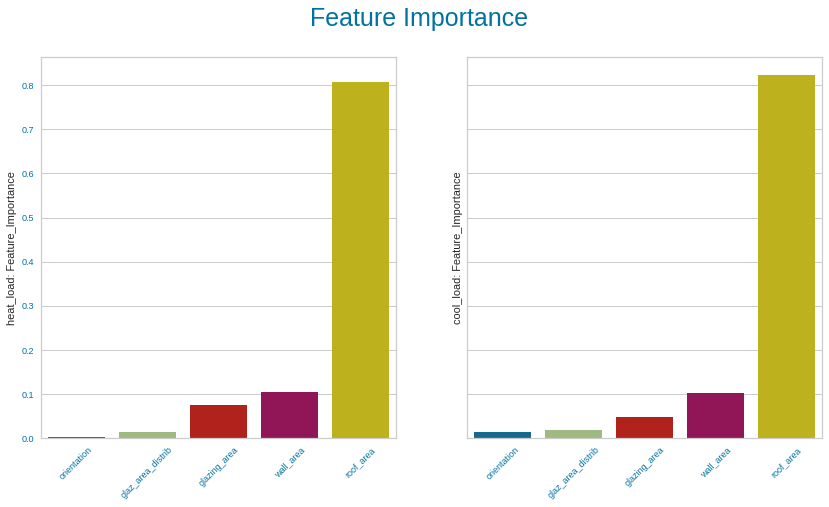

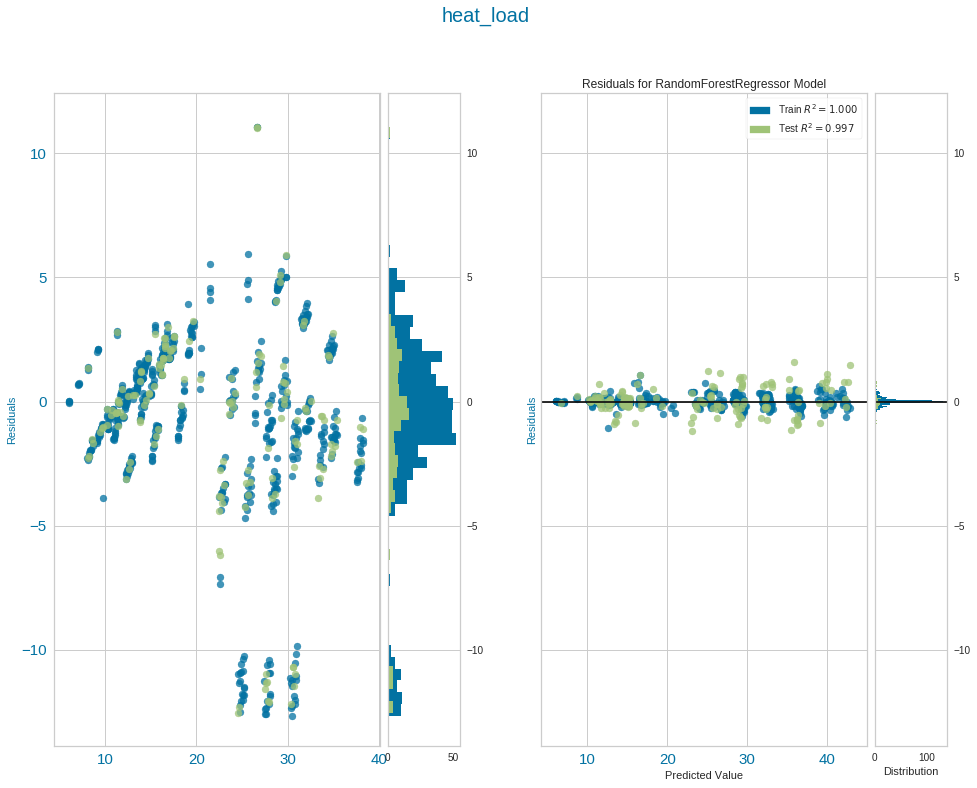

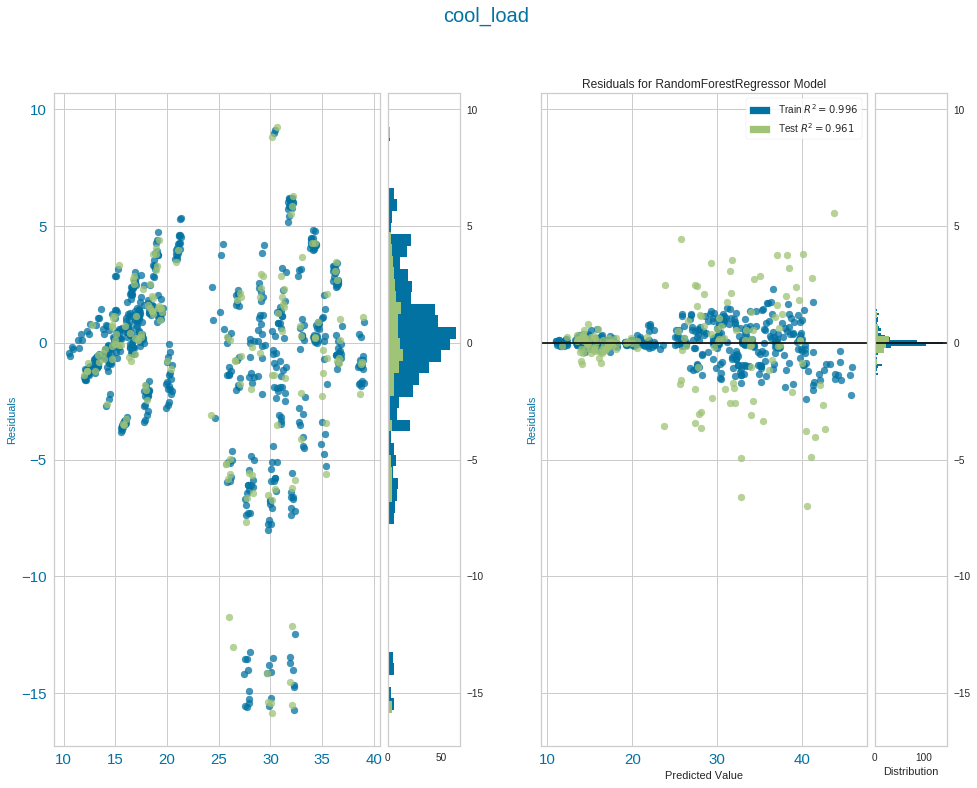

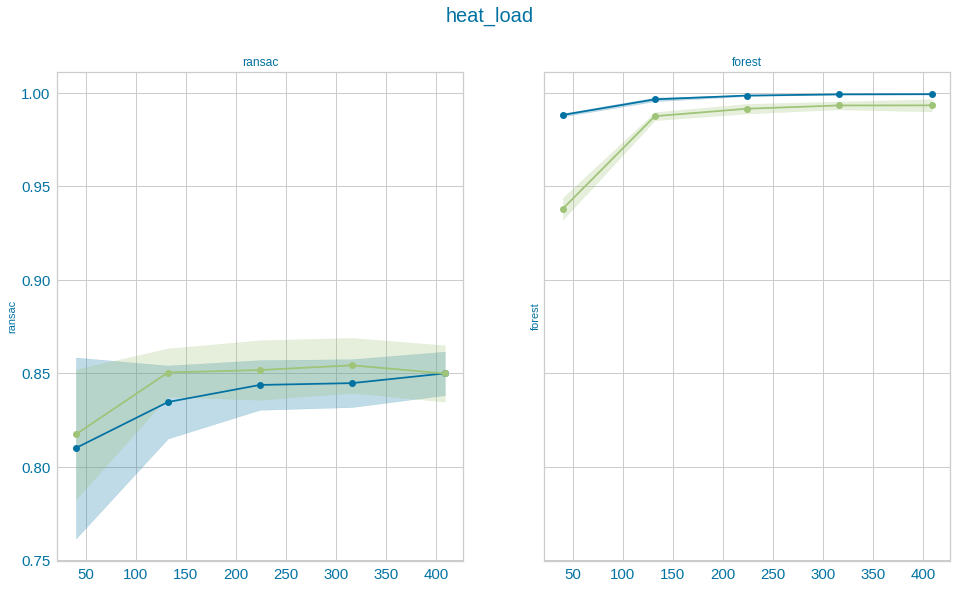

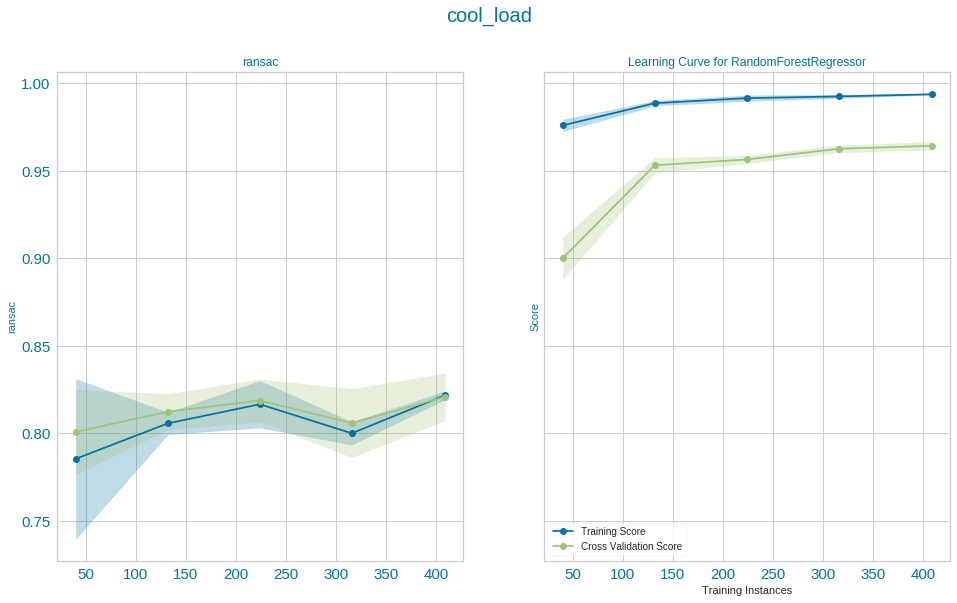

In [9]:
ML_dictEN2=load_object('ML_dictEN2.sav')
showFeatureImportanceForModels(ML_dict=ML_dictEN2)
showResidualsForModels(ML_dict=ML_dictEN2)
showLearningCurveForModels(ML_dict=ML_dictEN2)

# Predictions

Approach: model for prediction is either ransac or forest.
1) model is ransac: we predict using ransac predictor (lin regr)
2) model is forest: a) based on values for prediction (indep vars) and factor we find closest_lower and closest_higher in the train data: to_predict = {'x1': [4, 6], 'x2': [14, 16], 'x3': [7, 7], .......} , note that for 'x3' closest_lower and closest_higher are equal. That's because 

In [10]:
# predict = [1,400,47,44]

# if model == 'ransac':
#     predict = ransac

# if model == 'forest':


### Preparing data in order to find our model's min or max using scipy.optimize

In [13]:
from scipy import optimize as opt

predictor=ML_dictEN2['Y']['heat_load']['pred']['forest']['predictor']

print(xdata)
# first we match up the names of the variables with its place/index in X
x_id = {}
for num, name in enumerate(xdata.columns):
    x_id['index'+str(num)] = name
# So if you want to know name of third var in X, type: x_id['X2']
# print(x_id['X2']) # This gives X4
print(x_id)
# calculate min/max of all items in X

bounds = []
x0 = []
for key in x_id.keys():
    bounds.append((xdata[x_id[key]].min(), xdata[x_id[key]].max()))
    x0.append(xdata[x_id[key]].mean())
print(bounds)
print(x0)

rranges = []
{'index0': 'wall_area', 'index1': 'roof_area', 'index2': 'orientation', 'index3': 'glazing_area', 'index4': 'glaz_area_distrib'}
def generateSlices():
    '''Adjust the values in 'slices' and 'col_num_slice_val'. Then it generates slices'''
    
    # Size of the slices
    slices = {
        'slice1': 30,
        'slice2': 1,
        'slice3': .15,
    }

    # Select which column should have which slice - counting the colums from left to right, starting with 0.
    col_num_slice_val = {
        'slice1': [0,1], 
        'slice2': [2,4],
        'slice3': [3],
    } 
    
    # Generate empty list with length equal to number of columns
    x_slices = [None] * len(xdata.columns)

    # Use both's dict above to create the slices
    for key in col_num_slice_val.keys():
        for col in col_num_slice_val[key]:
            x_slices[col] = slices[key]
    return x_slices


x_slices = generateSlices()
print(x_slices)

def calcArraySize():
    array_size = 1
    for x, xslice in zip(bounds, x_slices):
        array_size *= math.ceil((x[1] - x[0])/xslice)
    return array_size
# print('calcArraySize:', calcArraySize())

'''Create the "rranges" to be used in "opt.brute"'''
for x, xslice in zip(bounds, x_slices):
    rranges.append(slice(x[0], x[1], xslice))

print(rranges)
def f(x):
    return predictor.predict(x.reshape(1,-1))

# ux_brute = opt.brute(f, rranges, full_output=True, finish=None) # comment out when runned

"""Saving the ux_brute"""

# obj_uxbrute = save_object(ux_brute, 'ux_brute') # comment out when saved

     surf_area  wall_area  roof_area  height  glazing_area  glaz_area_distrib
0        514.5      294.0     110.25     7.0           0.0                  0
1        514.5      294.0     110.25     7.0           0.0                  0
2        514.5      294.0     110.25     7.0           0.0                  0
3        514.5      294.0     110.25     7.0           0.0                  0
4        563.5      318.5     122.50     7.0           0.0                  0
..         ...        ...        ...     ...           ...                ...
763      784.0      343.0     220.50     3.5           0.4                  5
764      808.5      367.5     220.50     3.5           0.4                  5
765      808.5      367.5     220.50     3.5           0.4                  5
766      808.5      367.5     220.50     3.5           0.4                  5
767      808.5      367.5     220.50     3.5           0.4                  5

[768 rows x 6 columns]
{'index0': 'surf_area', 'index1': 'wall_

'Saving the ux_brute'

In [ ]:
"""Loading the ux_brute"""

ux_brute = load_object(
    '/home/jesper/Work/MLDA_app/MLDA/jupyter_ML/ux_brute.sav')

print('ux_brute[0]:', ux_brute[0])
print('ux_brute[1]', ux_brute[1])


In [42]:

ML_dictEN2 = load_object("/home/jesper/Work/MLDA_app/MLDA/jupyter_ML/ML_dictEN2.sav")
df_data, xdata_names = ML_dictEN2["df_data"], ML_dictEN2["xdata_names"]
xdata = df_data[xdata_names]
# predictor = ML_dictEN2["Y"]["heat_load"]["pred"]["ransac"]["predictor"]


def createNamesBoundsMeanDict(df_xdata=None):
    names_bounds_mean = {}
    for name in df_xdata.columns:
        names_bounds_mean[name] = [
            df_xdata[name].min(),
            df_xdata[name].max(),
            df_xdata[name].mean(),
        ]
    return names_bounds_mean


def addNamesBoundsAndMeanToML_dict(ML_dict=None):
    """Adding lowbounds dict and slopes dict to ML_dict
    Input:
    ML_dict: choose name of the dict, eg. ML_dictEN2
    names_low_mean_high_slopes: dict with names and lowbound, mean value, highbound and slopes
    Output: Not returning anything
    """
    df_data, xdata_names = ML_dict["df_data"], ML_dict["xdata_names"]
    # Create dict with names and low, mean, high values
    names_bounds_mean = createNamesBoundsMeanDict(df_xdata=df_data[xdata_names])

    # Adding bounds
    ML_dict["X_bounds"] = {
        name: names_bounds_mean[name][:2] for name in names_bounds_mean
    }
    ML_dict["X_means"] = {
        name: names_bounds_mean[name][-1] for name in names_bounds_mean
    }


# names_low_mean_high = createNamesBoundsMeanDict(df_xdata=xdata)
# print(names_low_mean_high)
# addNamesBoundsAndMeanToML_dict(ML_dict=ML_dictEN2)
# print(ML_dictEN2["X_bounds"])
# print(ML_dictEN2["X_means"])


def makeDFforLinearRegr(ML_dict=None):
    names_bounds = ML_dict["X_bounds"]
    names_means = ML_dict["X_means"]
    xdata_names = ML_dict["xdata_names"]
    # Create df in advanced with xdata_names as columns to keep correct order
    df = pd.DataFrame(columns=xdata_names)
    for name in xdata_names:
        # For each name init dict with two values for each name - values are means
        dict_to_df = {key: [names_means[key], names_means[key]] for key in names_means}
        # Now for name var replace means with low and high bounds
        dict_to_df[name][0], dict_to_df[name][1] = (
            names_bounds[name][0],
            names_bounds[name][1],
        )
        # Create df to paste dict_to_df in
        df_next = pd.DataFrame(data=dict_to_df)
        df = df.append(df_next, ignore_index=True)
    return df


# print(makeDFforLinearRegr(ML_dict=ML_dictEN2))


def f(x=None, predictor=None):
    """Function that takes an array and a predictor and returns an prediction array. 
    Approach: if not already a numpy array then make it one. And if input is a single row
    then reshape input.
    Input: 
    x: numpy array, pandas df/series or python list
    predictor: sklearn predictor
    """
    if not hasattr(x, "reshape"):
        x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    # NOTE: we use [0] to get scalar values in makeLinearRegrOnDF, apply
    return predictor.predict(x)[0]


def makeLinearRegrOnDF(ML_dict=None, yvar=None):
    # Call makeDFforLinearRegr to make DF
    df = makeDFforLinearRegr(ML_dict=ML_dict)
    predictor = ML_dictEN2["Y"][yvar]["pred"]["forest"]["predictor"]
    # Find slopes
    slopes, df = findSlopes(df_xdata_regr=df, predictor=predictor)
    return slopes[0]


# print(makeLinearRegrOnDF(ML_dict=ML_dictEN2, yvar="heat_load"))


def findYvalueForLowbounds(ML_dict=None, yvar=None):
    names_bounds = ML_dict["X_bounds"]
    xdata_names = ML_dict["xdata_names"]
    predictor = ML_dictEN2["Y"][yvar]["pred"]["forest"]["predictor"]
    # Create df in advanced with xdata_names as columns to keep correct order
    df = pd.DataFrame(columns=xdata_names)
    names_lowbounds = {key: [names_bounds[key][0]] for key in names_bounds}
    df_to_add = pd.DataFrame(data=names_lowbounds)
    df = df.append(df_to_add)
    df["Y0"] = df[df.columns].apply(f, args=(predictor,), axis=1)
    return df["Y0"].values[0]  # return Y0 as single scalar


# print(findYvalueForLowbounds(ML_dict=ML_dictEN2, yvar="heat_load"))


def findSlopesAndYvaluesForLowbounds(ML_dict=None, yvar=None):
    slopes = makeLinearRegrOnDF(ML_dict=ML_dict, yvar=yvar)
    Y_lowbounds = findYvalueForLowbounds(ML_dict=ML_dict, yvar=yvar)
    return slopes, Y_lowbounds


def collectSlopesAndYvaluesForLowbounds(ML_dict=None, yvars=None):
    ynames_slopes_y0 = {}
    for yvar in yvars:
        slopes, y0 = findSlopesAndYvaluesForLowbounds(ML_dict=ML_dict, yvar=yvar)
        ynames_slopes_y0[yvar] = dict(slopes=slopes, y0=y0)
    return ynames_slopes_y0


# ynames_slopes_y0 = collectSlopesAndYvaluesForLowbounds(
#     ML_dict=ML_dictEN2, yvars=["heat_load", "cool_load"]
# )
# print(ynames_slopes_y0)


def addSlopesAndY0toML_dictOptimizePart(ML_dict=None, ynames_slopes_y0=None):
    ML_dict["optimize"] = {}
    for name in ynames_slopes_y0:
        ML_dict["optimize"][name] = dict(
            slopes=ynames_slopes_y0[name]["slopes"], y0=ynames_slopes_y0[name]["y0"]
        )


# addSlopesAndY0toML_dictOptimizePart(
#     ML_dict=ML_dictEN2, ynames_slopes_y0=ynames_slopes_y0
# )

# save_object(ML_dictEN2, "ML_dictEN2")
ML_dictEN2 = load_object("ML_dictEN2.sav")
# print(ML_dictEN2["optimize"])


def f_linear(x=None, y0=None, lowbounds=None, slopes=None):
    X = np.array(x) - np.array(lowbounds)  # X: how far from lowbound, correct x
    Y_delta = np.array(slopes) * X
    Y_sum = []
    for entry in Y_delta:
        Y_sum.append(y0 + entry.sum())
    return Y_sum


y0 = ML_dictEN2["optimize"]["heat_load"]["y0"]
lowbounds = [ML_dictEN2["X_bounds"][name][0] for name in ML_dictEN2["xdata_names"]]
slopes = ML_dictEN2["optimize"]["heat_load"]["slopes"]
# print("y0:", y0)
# print()
# print("lowbounds:", lowbounds)
# print()
print("slopes:", slopes)

# print(
#     f_linear(
#         x=[[294, 220.5, 5, 0.0, 0], [294, 110.5, 2, 0.0, 0]],
#         y0=y0,
#         lowbounds=lowbounds,
#         slopes=slopes,
#     )
# )


def fBassin(x=None, yvar=None, ML_dict=ML_dictEN2, linear_frac=0.001):
    if not hasattr(x, "reshape"):
        x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)

    # random forest part
    rf_predictor = ML_dict["Y"][yvar]["pred"]["forest"]["predictor"]
    rf_predict = rf_predictor.predict(x)

    # linear part
    lowbounds = [ML_dict["X_bounds"][name][0] for name in ML_dict["xdata_names"]]
    slopes, y0 = ML_dict["optimize"][yvar]["slopes"], ML_dict["optimize"][yvar]["y0"]
    lin_predict = np.array(f_linear(x=x, y0=y0, lowbounds=lowbounds, slopes=slopes))

    return rf_predict * (1 - linear_frac) + lin_predict * linear_frac


# 6.65849274
# print(fBassin(x=x, yvar="heat_load", ML_dict=ML_dictEN2))

bounds, x0 = [ML_dictEN2['X_bounds'][key] for key in xdata_names], [ML_dictEN2['X_means'][key] for key in xdata_names]
print(x0)
print(bounds)
# x0=[394, 120.5, 3.5, 0.0, 3.0]
# bounds=[[245.0, 245.01], [220.4, 220.5], [2, 2.001], [0.0, 0.01], [0, 5]]
# # minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds, args=predictor)
# minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds, args='heat_load')
# ux_basin = opt.basinhopping(func=fBassin, x0=x0, niter=50, stepsize=.1, minimizer_kwargs=minimizer_kwargs)
# print(ux_basin.x)
# print(ux_basin.fun)
# print(ML_dictEN2['df_data'])
# [318.5, 176.60416666666666, 3.5, 0.234375, 2.8125]
# ux_basin.x: [245.  220.5   2.    0.    5. ]
# ux_basin.fun: [7.89896359]
# x = [[245, 220.5, 2, 0.0, 5], [294, 220.5, 3.5, 0.0, 0]]
# #
result = 100
x_and_func = []
for i in np.linspace(0,5,50):
    x=[245, 220.5, 2, 0.0, i]
    func = fBassin(x=x, yvar="heat_load", ML_dict=ML_dictEN2)
    if func<result:
        result=func
        x_and_func.append([i, func])
print(x_and_func)
# print(fBassin(x=x, yvar="heat_load", ML_dict=ML_dictEN2))

slopes: [ 0.05996264 -0.13739629  0.11029333 20.49382541 -0.21172591]
[318.5, 176.60416666666666, 3.5, 0.234375, 2.8125]
[[245.0, 416.5], [110.25, 220.5], [2, 5], [0.0, 0.4], [0, 5]]
[[0.0, array([6.06799666])], [0.10204081632653061, array([6.06797505])], [0.20408163265306123, array([6.06795345])], [0.30612244897959184, array([6.06793185])], [0.40816326530612246, array([6.06791024])]]


In [ ]:
"""Basin hopping"""

ML_dictEN2=load_object('ML_dictEN2.sav')
df_data, xdata_names = ML_dictEN2['df_data'], ML_dictEN2['xdata_names']
xdata = df_data[xdata_names]
predictor=ML_dictEN2['Y']['heat_load']['pred']['ransac']['predictor']

def createNamesLowMeanHighDict(df_xdata=None):
    names_low_mean_high = {}
    for name in df_xdata.columns:
        names_low_mean_high[name]=[df_xdata[name].min(),df_xdata[name].mean(), df_xdata[name].max()]
    return names_low_mean_high

names_low_mean_high=createNamesLowMeanHighDict(df_xdata=xdata)
print(names_low_mean_high)

def createNamesSlopesDict(names_low_mean_high=None):
    names_slopes = {}
    for var in names_low_mean_high:
        dict_for_df = {key: [names_low_mean_high[key][1], names_low_mean_high[key][1]] for key in names_low_mean_high}
        dict_for_df[var][0], dict_for_df[var][1] = names_low_mean_high[var][0], names_low_mean_high[var][2]
        df = pd.DataFrame(data=dict_for_df)
        from MLDA.ML_functions.rf_tail_interpolation import findSlopeSingleVar
        slope = findSlopeSingleVar(df_xdata_regr=df, predictor=predictor, var=var)
        names_slopes[var] = slope[0]
    return names_slopes
        
names_slopes = createNamesSlopesDict(names_low_mean_high=names_low_mean_high)
print(names_slopes)



def fBassin(x=None, predictor=None, slopes_dict=None, xdata_names=None, slope_contrib_frac=.05):
    if not hasattr(x, "reshape"):
        x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    prediction = predictor.predict(x)
    
    slopes_list = [slopes_dict[key] for key in xdata_names]
    sum_slope_list = []
    slopes_times_x = np.array(slopes_list) * x
    for entry in slopes_times_x:
        sum_slope_list.append(entry.sum())
    contrib_slopes = np.array(sum_slope_list) * slope_contrib_frac
    return prediction + contrib_slopes

print(fBassin(x=[[294, 220.5, 3.5, 0., 0],[294, 220.5, 3.5, 0., 0]], predictor=predictor, slopes_dict=names_slopes, xdata_names=xdata_names))


def f(x=None, predictor=None):
    if not hasattr(x, "reshape"):
        x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    return predictor.predict(x)

# minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds, args=predictor)
# ux_basin = opt.basinhopping(func=f, x0=x0, niter=200, stepsize=.01, minimizer_kwargs=minimizer_kwargs)
# print(ux_basin.x)
# print(ux_basin.fun)
print(f(x=[[514.5, 294, 220.5, 3.5, 0., 0],[514.5, 294, 220.5, 3.5, 0., 0]], predictor=predictor))

print(predictor.predict(xdata.loc[0,:].to_numpy().reshape(1, -1)))
xdata.loc[0,:]


In [ ]:
from MLDA.plot_functions.model_visual import xyZ_forSurfaceplot, surfacePlotly, forAnimationPlot, plotlyAnimation, validationPlot,findVarsForPlot

# Loading data
data = load_object(
    "/home/jesper/Work/MLDA_app/MLDA/jupyter_DA/energy_data.sav")
xdata = data.iloc[:, 1:-2]

# Loading random forest regressor
rf_regressor = load_object(
    "/home/jesper/Work/MLDA_app/MLDA/jupyter_ML/forest_saved.sav")

# Functions
def f(x):
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    return rf_regressor.predict(x)


opt_values = [674.5, 245.0, 190.25, 3.5, 4.0, 0.0, 0.0]
bounds = [
    (514.5, 808.5),
    (245.0, 416.5),
    (110.25, 220.5),
    (3.5, 7.0),
    (2, 5),
    (0.0, 0.4),
    (0, 5),
]
# most important features: x5, x2, x4

# Dict's for optimal values and bounds
names_and_opt_values = {
    name: value
    for name, value in zip(xdata.columns, opt_values)
}
# print

In [ ]:
from MLDA.plot_functions.model_visual import xyZ_forSurfaceplot, surfacePlotly, forAnimationPlot, plotlyAnimation, validationPlot

# Loading data
data = load_object(
    "/home/jesper/Work/MLDA_app/MLDA/jupyter_DA/energy_data.sav")
xdata = data.iloc[:, 1:-2]

# Loading random forest regressor
rf_regressor = load_object(
    "/home/jesper/Work/MLDA_app/MLDA/jupyter_ML/forest_saved.sav")


# Functions
def f(x):
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    return rf_regressor.predict(x)

print(f(np.array([674.5, 245.0, 190.25, 3.5, 4.0, 0.0, 0.0])))
opt_values = [674.5, 245.0, 190.25, 3.5, 4.0, 0.0, 0.0]
bounds = [
    (514.5, 808.5),
    (245.0, 416.5),
    (110.25, 220.5),
    (3.5, 7.0),
    (2, 5),
    (0.0, 0.4),
    (0, 5),
]

# Automatic selection of most relevant variables to plot
da_dict = load_object(
    '/home/jesper/Work/MLDA_app/MLDA/jupyter_DA/da_dict_N1.sav')
ml_dict = load_object('train_test_dict.sav')
num_for_plot = 3
xdata_names=ml_dict['N1']['xdata_names']
xdata_numpy=ml_dict['N1']['X']['x_train']

level = .5
df_corr, df_feat_imp = da_dict['correlation'], ml_dict["N1"]["Y"]["heat_load"]["pred"]["forest"]["df_feat_imp"]
vars_to_plot=findVarsForPlot(num_for_plot=num_for_plot, xdata_names=xdata_names, df_corr=df_corr, df_feat_imp=df_feat_imp, level=level)
# print(vars_to_plot)

x, y, frame_var = vars_to_plot['var1'], vars_to_plot['var2'], vars_to_plot['var3']
# x_steps, y_steps, num_frames = 30, 30, 30

# Predictor
# 'Y': {'yname1': {'pred':{'ransac': {'train': np.arrays, 'test': np.arrays, 'predictor'
predictor = ml_dict['N1']['Y']['heat_load']['pred']['forest']['predictor']
# print(predictor)
# Dict's for optimal values and bounds
names_and_opt_values = {
    name: value
    for name, value in zip(xdata.columns, opt_values)
}
# print(names_and_opt_values)

names_and_bounds = {name: value for name, value in zip(xdata.columns, bounds)}



def forAnimationPlot(
    predictor=predictor
    dict_namesbounds=names_and_bounds,
    dict_namesvalues=names_and_opt_values,
    df_xdata=,
    xvar_str=None,
    yvar_str=None,
    frame_var_str=None,
    reshape_transpose=True,
)



# predictor = f
# x_lin, y_lin, Z = xyZ_forSurfaceplot(predictor=f,
#                                      dict_namesbounds=names_and_bounds,
#                                      dict_namesvalues=names_and_opt_values,
#                                      xdata=xdata,
#                                      x=x,
#                                      y=y,
#                                      x_steps=x_steps,
#                                      y_steps=y_steps,
#                                      reshape_transpose=True)

# surfacePlotly(
#     x_points=x_points,
#     y_points=y_points,
#     Z_array=Z,
#     xvar_str="height",
#     yvar_str="roof_area",
#     x_opt=(3.5,),
#     y_opt=(220.5,),
#     z_opt=(6.048,),
# )

# # old surfacePlotly(x=x, y=y, z=Z, x_lin=x_lin, y_lin=y_lin)

# x_lin, y_lin, var_lin, Z_dict = forAnimationPlot(
#     predictor=f,
#     dict_namesbounds=names_and_bounds,
#     dict_namesvalues=names_and_opt_values,
#     xdata=xdata,
#     x=x,
#     y=y,
#     x_steps=x_steps,
#     y_steps=y_steps,
#     frame_var=frame_var,
#     num_frames=num_frames,
#     reshape_transpose=True)

# plotlyAnimation(x=x,
#                 y=y,
#                 frame_var=frame_var,
#                 x_lin=x_lin,
#                 y_lin=y_lin,
#                 var_lin=var_lin,
#                 Z_dict=Z_dict)

# validationPlot(vars=[x, y, frame_var],
#                steps=[20, 20, 20],
#                xdata=xdata,
#                dict_namesvalues=names_and_opt_values,
#                dict_namesbounds=names_and_bounds,
#                levels=[0, .3, .7, 1],
#                level_vars=[x, y],
#                predictor=f)